In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import tqdm
import argparse
import os
import dataclasses
import numpy

from pathlib import Path
from util import FormatWriter

from util import TensorCollectionSuiteSparse, ScipyTensorShifter, \
    ScipyMatrixMarketTensorLoader, SuiteSparseTensor, safeCastScipyTensorToInts


In [4]:
SS_PATH = os.getenv('SUITESPARSE_PATH')

ssMtx = dataclasses.make_dataclass("SS", [("name", str), ("nnz", int),
                                          ("dim1", int), ("dim2", int),
                                          ("sparsity", float), ("seg_size", int),
                                          ("crd_size", int)])

fiber_data = dataclasses.make_dataclass("FIBER", [("name", str), ("dcsr0", int),
                                          ("dcsr1", [int]), ("dcsc0", int),
                                          ("dcsc1", [int]), ])


In [5]:
print(SS_PATH)

/home/oliviahsu/Documents/research/datasets/suitesparse


In [6]:
# UfuncInputCache attempts to avoid reading the same tensor from disk multiple
# times in a benchmark run.
class UfuncInputCache:
    def __init__(self):
        self.lastLoaded = None
        self.lastName = None
        self.tensor = None
        self.other = None

        self.shifter = ScipyTensorShifter()

    def load(self, tensor, suitesparse, cast):
        if self.lastName == str(tensor):
            return self.tensor, self.other
        else:
            if suitesparse:
                self.lastLoaded = tensor.load(ScipyMatrixMarketTensorLoader())
            else:
                self.lastLoaded = tensor.load()
            self.lastName = str(tensor)
            if cast:
                self.tensor = safeCastScipyTensorToInts(self.lastLoaded)
            else:
                self.tensor = self.lastLoaded

            self.other = self.shifter.shiftLastMode(self.lastLoaded)

            return self.tensor, self.other


inputCache = UfuncInputCache()

In [7]:
def fiber_stats(ss_tensor, tensor_coo, other_coo, show=False):
    print("Getting fiber stats...")
    formatWriter = FormatWriter(True)
    dcsr = formatWriter.convert_format(tensor_coo, "dcsr")
    dcsc = formatWriter.convert_format(tensor_coo, "dcsc")

    fiber_data_list = {}
    fiber_data_list['dcsr0'] = [dcsr.seg0[x + 1] - dcsr.seg0[x] for x in range(len(dcsr.seg0)-1)][0]
    fiber_data_list['dcsr1'] = [dcsr.seg1[x + 1] - dcsr.seg1[x] for x in range(len(dcsr.seg1)-1)]
    fiber_data_list['dcsc0'] = [dcsc.seg0[x + 1] - dcsc.seg0[x] for x in range(len(dcsc.seg0)-1)][0]
    fiber_data_list['dcsc1'] = [dcsc.seg1[x + 1] - dcsc.seg1[x] for x in range(len(dcsc.seg1)-1)]

    if show:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
        counter = 0
        for i in range(2):
            for j in range(2):

                ax = axes[i][j]

                # Plot when we have data
                if counter < len(fiber_data_list):

                    key = sorted(list(fiber_data_list.keys()))[counter]
                    ax.hist(fiber_data_list[key], color='blue', alpha=0.5,
                            label='{}'.format(counter))

                # Remove axis when we no longer have data
                else:
                    ax.set_axis_off()

                counter += 1

        plt.show()

    return fiber_data(ss_tensor, **fiber_data_list)

In [8]:
def run_mtx(name):
    filename = name + ".mtx"
    print("Processing %s" % filename)

    ss_tensor = SuiteSparseTensor(os.path.join(SS_PATH, filename))
    tensor_coo, other_coo = inputCache.load(ss_tensor, True, False)

    df = None
    if not isinstance(ss_tensor, numpy.ndarray):
        df = fiber_stats(ss_tensor, tensor_coo, other_coo)
    return df

In [9]:
matrices = ['bcsstm02', 'lp_scsd1']
dfs = pd.DataFrame([run_mtx(x) for x in matrices])
print(dfs)

Processing bcsstm02.mtx
Getting fiber stats...
Processing lp_scsd1.mtx
Getting fiber stats...
       name  dcsr0                                              dcsr1  dcsc0  \
0  bcsstm02     66  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...     66   
1  lp_scsd1     77  [24, 20, 24, 20, 24, 20, 24, 20, 24, 20, 24, 2...    760   

                                               dcsc1  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, ...  


<AxesSubplot:>

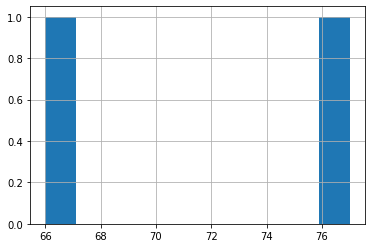

In [10]:
dfs['dcsr0'].hist()


<AxesSubplot:>

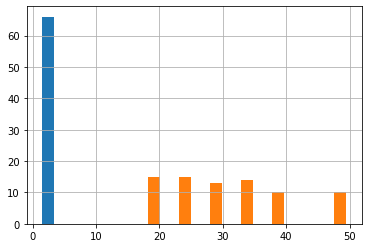

In [11]:
dfs['dcsr1'].hist()

<AxesSubplot:>

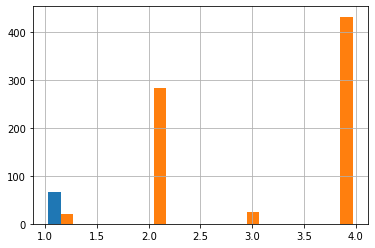

In [12]:
dfs['dcsc1'].hist()

In [16]:
def read_tensor_names(filename):
    result = None
    with open(filename, "r") as f:
        result = f.read().splitlines()
    return result

In [20]:
small50 = read_tensor_names("suitesparse_valid_small50.txt")

In [21]:
dfs = pd.DataFrame([run_mtx(x) for x in small50])

Processing Trec4.mtx


FileNotFoundError: [Errno 2] No such file or directory: '/home/oliviahsu/Documents/research/datasets/suitesparse/Trec4.mtx'